# Spatio-temporal prediction of temperature fields with Deep Learining

In this notebook we will introduce a methodology to perform interpolation of spatio-temporal datasets with deep learning models, capturing the spatial, temporal and spatio-temporal dependencies in data. We will here apply the method on real case study.


## This notebook is modified from the original [notebook](https://github.com/federhub/ST_DeepLearning/blob/master/Code/Experiment_TemperatureData.ipynb). 

Credit goes to the original authors. We're using their methods on our data

In [1]:
import io
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

2023-06-01 15:21:18.282701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 15:21:18.705664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Import data files

**This is something that you will want to change.**

I have compressed all of our data into a single zip file `data.zip`.

The `y_train.txt` & `y_test.txt` are CSV files containing the expected output for the models: Quoting [this issue](https://github.com/federhub/ST_DeepLearning/issues/1). Note that these CSV files contain no column labels.

> These are 2d DataFrames of the temperature, where each row is a different spatial location (e.g. one of our MeteoSuisse monitoring stations) and each column is a different timestamp. Diversely said, each row is the time series of temperature for a single location (monitoring station). The timestamps are in this example the same throughout all the stations and there are no missing data as they have previously been imputed.

The `X_train.txt` & `X_text.txt` are also CSV files containing the input features for training model.

> Each row is a station, in the same order as (y_train, y_test) data, and each column is a different feature. The columns are labeled. We are using these 6 features (**You may want to use another set of features**):
1. X = longitude
2. Y = latitude
3. pr_mn = mean precipitation
4. tmin = mean temp min
5. tmax = mean temp max
6. vpd = vapor pressure index (humidity)

The `gr_gridmet.csv` file is in the same format at the X_train.txt with a header but this file contains data to predict.

In [2]:
# I am using class variables to encapsulate file name constants


class FileName:
    zip = "chickens.zip"

    y_train = "eeev_train_red.txt"
    y_test = "eeev_train_red.txt"

    X_train = "Xtrain_eeev_gridMET.txt"
    X_test = "Xtest_eeev_gridMET.txt"

    predict = "gr_gridmet.csv"

## Colab vs local notebook setup

If you are running a colab notebook you will be prompted for a locally stored zip file.

On my machine I have placed my `data` directory that is parallel to this directory directory. Like so:

```
$ tree -d .
.
├── data
├── docs
└── notebooks
```

In [3]:
COLAB = False

In [4]:
if COLAB:
    from google.colab import files
    uploaded = files.upload()

    zippy = zipfile.ZipFile(io.BytesIO(uploaded[FileName.zip]), "r")
    zippy.extractall()

    DATA_DIR = Path(".")

else:
    DATA_DIR = Path("..") / "data"

## Given the above COLAB setup read in the data

In [5]:
y_train = pd.read_csv(DATA_DIR / FileName.y_train, header=None, index_col=None)
y_test = pd.read_csv(DATA_DIR / FileName.y_test, header=None, index_col=None)

X_train = pd.read_csv(DATA_DIR / FileName.X_train, index_col=None)
X_test = pd.read_csv(DATA_DIR / FileName.X_test, index_col=None)

predict = pd.read_csv(DATA_DIR / FileName.predict)

predict.head()

,X,Y,pr_mn,tmin,tmax,vpd
0,-81.516667,30.483333,4.689796,293.536326,302.073878,0.960571
1,-81.475000,30.483333,4.269388,293.737959,301.997551,0.974286
2,-81.433333,30.483333,4.088163,293.984490,301.996327,1.005061
3,-81.391667,30.483333,3.772653,294.184490,301.881224,1.016816
4,-81.350000,30.483333,3.743673,293.100000,301.342041,0.864776


## SVD decomposition of training data

We want to decompose the training target values using a SVD (EOF).  In this way we will obtain three objcets: a set of principal component time series, a set of eigenvalues and a set of spatial coeffiecents. Moreover, we need to store the temporal mean of the raw data. As we will subtract this quantity before performing svd, we will need it later on to reconstruct the original signal.
The decomposition is done accoring to Wikle, 2019.

In [6]:
Z = tf.constant(y_train, dtype=tf.float32)  # I think this is the data 1 and 0

# print('Matrix Z: \n{}\n'.format(Z))

2023-06-01 15:21:19.253402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 15:21:19.272827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 15:21:19.272957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
time_mean = tf.reduce_mean(Z, 0)
print(time_mean)

nS = tf.constant(Z.shape[0], dtype=tf.float32)
time_mean = tf.reshape(tf.tile(time_mean, [nS]), [nS, time_mean.shape[0]])

Ztime_detrend = Z - time_mean
Ztilde = 1 / tf.sqrt(nS - 1) * Ztime_detrend

# print('Matrix Ztilde: \n{}\n'.format(Ztilde))

tf.Tensor(
[0.2857143  0.35714287 0.21428572 0.14285715 0.         0.2857143
 0.07142857 0.14285715 0.         0.         0.         0.
 0.14285715 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ], shape=(28,), dtype=float32)


In [8]:
s, u, v = tf.linalg.svd(Ztilde)
u = u * tf.sqrt(nS - 1)

# print('Diagonal S: \n{} \n\nMatrix U: \n{} \n\nMatrix V^T: \n{}'.format(s, u, v))

2023-06-01 15:21:19.832085: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x81e8ad0


Plot the first three elements of the temporal basis and the corresponding spatial coefficients

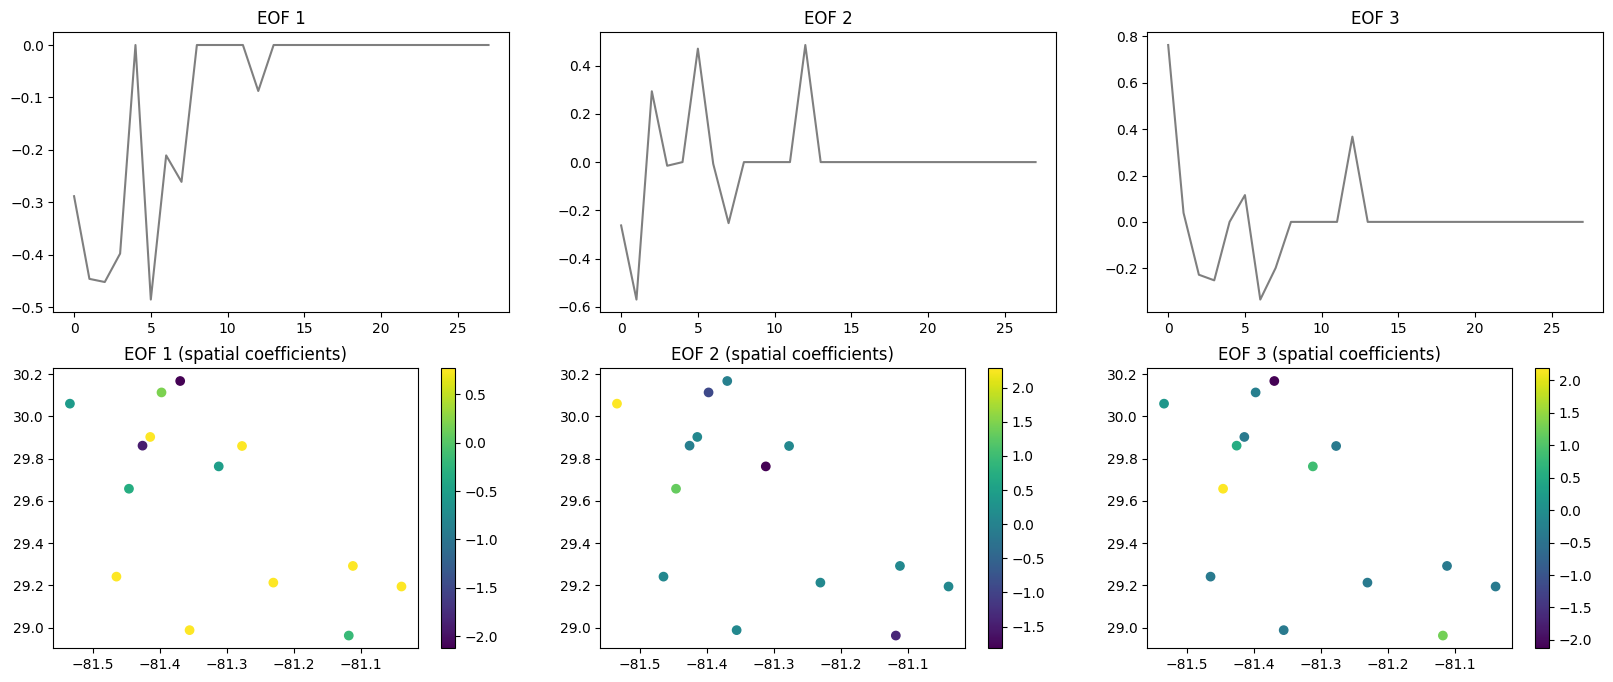

In [9]:
def plot_1st_3_elements(X_data, uu, vv):
    plt.figure(figsize=(20, 8))

    plt.subplot(2, 3, 1)
    plt.plot(np.arange(len(vv[:, 0])), vv[:, 0], color="black", alpha=0.5)
    plt.title("EOF 1")

    plt.subplot(2, 3, 2)
    plt.plot(np.arange(len(vv[:, 1])), vv[:, 1], color="black", alpha=0.5)
    plt.title("EOF 2")

    plt.subplot(2, 3, 3)
    plt.plot(np.arange(len(vv[:, 2])), vv[:, 2], color="black", alpha=0.5)
    plt.title("EOF 3")

    plt.subplot(2, 3, 4)
    plt.scatter(X_data["X"], X_data["Y"], c=uu[:, 0])
    plt.colorbar()
    plt.title("EOF 1 (spatial coefficients)")

    plt.subplot(2, 3, 5)
    plt.scatter(X_data["X"], X_data["Y"], c=uu[:, 1])
    plt.colorbar()
    plt.title("EOF 2 (spatial coefficients)")

    plt.subplot(2, 3, 6)
    plt.scatter(X_data["X"], X_data["Y"], c=uu[:, 2])
    plt.colorbar()
    plt.title("EOF 3 (spatial coefficients)")


plot_1st_3_elements(X_train, u, v)

We can plot the percentage of explained variance.

In [10]:
def plot_percent_var(ss, n_eof):
    count = len(ss)
    plt.figure(figsize=(count, 2.25))
    plt.plot(
        np.arange(count),
        (np.cumsum(tf.math.square(s) / tf.reduce_sum(tf.math.square(ss))))[:count],
        c="black",
    )
    plt.axhline(0.9503357, color="black", linestyle="--", linewidth=1)
    plt.axvline(n_eof, ymax=0.885, color="black", linestyle="--", linewidth=1)
    plt.ylabel("Cumulative \n explained variance")
    plt.xlabel("Number of components")


plot_percent_var(s)

TypeError: plot_percent_var() missing 1 required positional argument: 'n_eof'

## Check if we can reconstruct the data

To verify if we correctly decompose data, we can reconstruct the original signal and check if we obtain the same values of wind speed as in the origianl dataset.

In [ ]:
Z_approx = tf.matmul(
    u / tf.sqrt(nS - 1),
    tf.matmul(tf.linalg.diag(s), v, adjoint_b=True),
)

reconstructed = Z_approx * tf.sqrt(nS - 1) + time_mean

tolerance = 1e-5

tf.math.reduce_any(tf.math.abs(reconstructed - Z) > tolerance)